# Energy-Based GAN

discriminator를 기존의 확률을 반환하는 것으로 보지 않고 에너지 함수로 생각한다.  
주어진 데이터가 데이터 매니폴드에 가까울수록 낮은 에너지를 그렇지 않으면 높은 에너지를 반환하게 한다.

내용 요약  
1. GAN training 시에 energy-based model 사용
2. EBGAN이 내재된 데이터 분포를 따르는 포인트를 생성
3. 판별자 auto-encoder 구조로 하면 reconstruction error 로 energy를 구한다.
4. 좋은 결과를 가진 EBGAN과 GAN의 hyper-parameter 선택과 architectural 선택
5. ImageNet dataset을 이용해서 high-resolution 이미지 생성


## Object function

$$𝓛_D(x,z) = D(x) + max(0,m-D(G(z)))$$
$$𝓛_G(z) = D(G(z))$$  

D의 목적함수 뒤에는 Hinge Loss라고 하며 어떤 양수 $m$ 에 대해서 reconstruction error가 $m$ 보다 작은 경우에만 gradient를 갖게 한다. 즉 fake에 대해 energy가 크면 학습을 하지 않도록 함

## EBGAN with auto-encoder discriminator

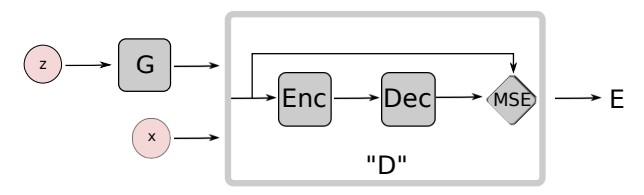

이때 $D(x) = \parallel Dec(Enc(x)) - x \parallel $  

autoencoder 학습 과정에서 가장 일반적인 문제는 에너지가 0이 되는 것이다.  
이러한 문제를 피하려면 매니폴드 바깥 부분에는 높은 에너지를 할당할 필요가 있는데,  
EBGAN에서는 매니폴드 바깥 부분의 데이터에 대해서는 높은 에너지를 갖게 하므로 생성자를 regularization으로 볼수 있다.

더해서 mode dropping 같은 문제를 방지하기 위해 Repelling regularizer를 제안  

$$ f_{PT}(S) = \frac{1}{N(N-1)}∑_{i}∑_{i\ne j} \left( \frac{S_{i}^TS_j}{\parallel S_i\parallel \parallel S_j \parallel} \right)$$  

PT로 학습된 EBGAN을 EBGAN-PT라 한다.

## Experiments

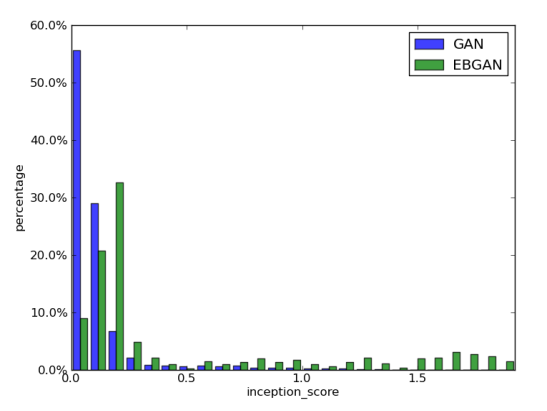

inception score를 생성 품질을 측정하는 척도로 사용하여 생성 품질을 비교  
오른쪽에 많이 분포할수록 생성 품질이 좋은것으로 볼 수 있다.  

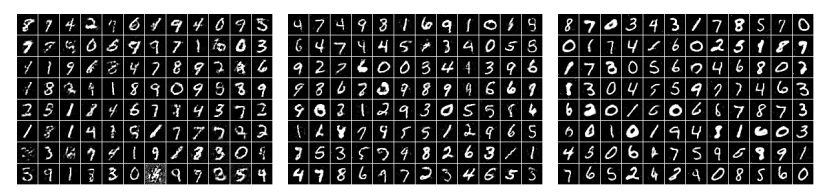

왼쪽부터 GAN, EBGAN, EBGAN-PT 비교  
왼쪽으로 갈수록 더욱 선명한 샘플을 얻는 것을 확인

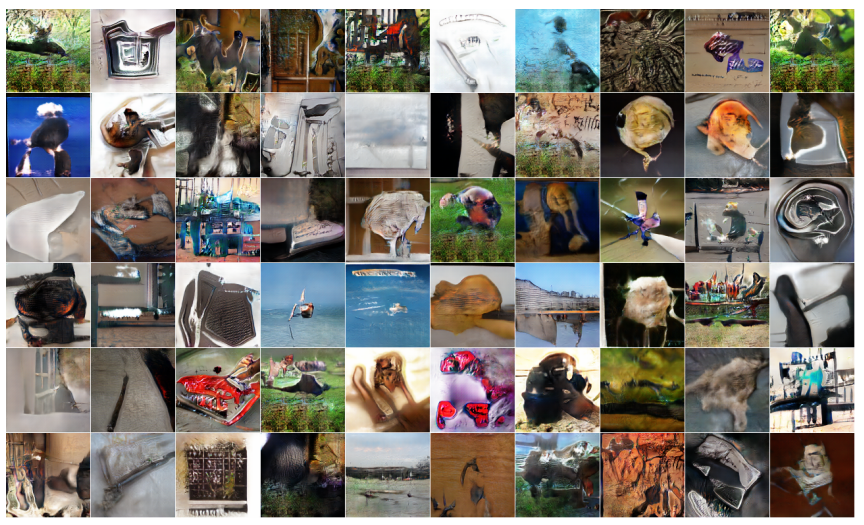

ImageNet으로 부터 생성한 샘플 (EBGAN-PT)

# 코드 실습

In [2]:
# 라이브러리 임포트
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils

import tqdm
from tqdm.notebook import tqdm as tqdm_nb

import matplotlib.pyplot as plt
import numpy as np
import os

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# 변수 정의

workers = 16
batch_size = 128
image_size = 64

nc = 3
nz = 100
ngf = 64
ndf = 64

lr = 0.0001
beta1 = 0.5
beta2 = 0.999

ngpu = 1
device = torch.device('cuda' if (torch.cuda.is_available() and ngpu > 0) else 'cpu')
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/

In [ ]:
file_list = os.listdir('/content/drive/MyDrive/Colab Notebooks/Datasets/CelebA/img_align_celeba')

for file in file_list:
  if not file.endswith('.jpg'):
    print(file)

In [4]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/Datasets')
os.listdir('./CelebA/')

['img_align_celeba']

In [10]:
# 데이터 로드
os.chdir('/content/drive/MyDrive/Colab Notebooks/Datasets')
folder_path = './CelebA'
train_dataset = datasets.ImageFolder(root=folder_path,
                                     transform=transforms.Compose([transforms.Resize(image_size),
                                                                   transforms.CenterCrop(image_size),
                                                                   transforms.ToTensor(),
                                                                   transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]))
dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [11]:
# EBGAN-PT

def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # 1x1x100
            nn.ConvTranspose2d(nz, 4 * ngf, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # 4x4x256
            nn.ConvTranspose2d(4 * ngf, 4 * ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # 8x8x256
            nn.ConvTranspose2d(4 * ngf, 2 * ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # 16x16x128
            nn.ConvTranspose2d(2 * ngf, 1 * ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 1),
            nn.ReLU(True),
            # 32x32x64
            nn.ConvTranspose2d(1 * ngf,  nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # 64x64x3
        )
        
    def forward(self, input):
      return self.main(input)
      
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.encoder = nn.Sequential(
            # 64x64x3
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True),
            # 32x32x64
            nn.Conv2d(ndf, 2 * ndf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(2 * ndf),
            nn.LeakyReLU(0.2, inplace=True),
            # 16x16x128
            nn.Conv2d(2 * ndf, 4 * ndf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(4 * ndf),
            nn.LeakyReLU(0.2, inplace=True),
            # 8x8x256
            nn.Conv2d(4 * ndf, 8 * ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
            # 4x4x512
        )
        self.decoder = nn.Sequential(
            # 4x4x512
            nn.ConvTranspose2d(8 * ndf, 4 * ndf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.ReLU(True),
            # 8x8x256
            nn.ConvTranspose2d(4 * ndf, 2 * ndf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.ReLU(True),
            # 16x16x128
            nn.ConvTranspose2d(2 * ndf, 1 * ndf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 1),
            nn.ReLU(True),
            # 32x32x64
            nn.ConvTranspose2d(1 * ndf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # 64x64x3
        )

    def forward(self, input):
      emb = self.encoder(input)
      out = self.decoder(emb)
      return emb, out

def Pulling_away_Term(s1,s2):
  n = s1.size(0)
  s1 = F.normalize(s1, p=2, dim=1)
  s2 = F.normalize(s2, p=2, dim=1)

  S1 = s1.unsqueeze(1).repeat(1, s2.size(0), 1)
  S2 = s2.unsqueeze(0).repeat(s1.size(0), 1, 1)

  f_PT = S1.mul(S2).sum(-1).pow(2)
  f_PT = torch.tril(f_PT, -1).sum().mul(2).div((n*(n-1)))

  #f_PT = (S1.mul(S2).sum(-1).pow(2).sum(-1)-1).sum(-1).div(n*(n-1))
  return f_PT

In [12]:
netG = Generator().to(device)
netD = Discriminator().to(device)

netG.apply(weights_init)
netD.apply(weights_init)

optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, beta2))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, beta2))

In [19]:
# https://github.com/1Konny/EBGAN-pytorch/blob/master/solver.py

img_list = []
G_losses = []
D_losses = []

pbar = tqdm_nb()
piter = 0
m = 1
num_epochs = 50
print("Starting Training Loop...")

for epoch in range(num_epochs):

    epoch_steps = len(dataloader)
    pbar.reset(total=epoch_steps)
    for i, data in enumerate(dataloader, 0):
        pbar.update()
        piter += 1
        # D 학습
        if i % 7 == 0:
          netD.zero_grad()
          
          real_img = data[0].to(device)
          b_size = real_img.size(0)
          noise = torch.randn(b_size, nz, 1, 1, device=device)
          fake_img = netG(noise)
          # Reconstruction Loss
          _, real_outs = netD(real_img)
          RELoss = F.mse_loss(real_img, real_outs)
          # Simple Hinge Loss
          _, fake_outs = netD(fake_img)
          fake_loss = F.mse_loss(real_img, fake_outs)
          SHLoss = torch.max(m - fake_loss, torch.zeros_like(fake_loss))

          DLoss = RELoss + SHLoss
          DLoss.backward()
          optimizerD.step()   
          
        # G 학습
        if i % 1 == 0:
          netG.zero_grad()
          fake_img = netG(noise)
          # fake Loss
          embs, fake_outs = netD(fake_img)
          FKLoss = F.mse_loss(real_img, fake_outs)
          # PT
          PT = 0#Pulling_away_Term(embs,embs)
          GLoss = FKLoss + PT
          GLoss.backward()
          optimizerG.step()

          desc = '[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f' \
                  % (epoch+1, num_epochs, i, epoch_steps, DLoss.item(), GLoss.item())
          pbar.set_description(desc)

          G_losses.append(GLoss.item())
          D_losses.append(DLoss.item())

        # fake image 생성
        #if (piter - 1) % 5 == 0:
        #    with torch.no_grad():
        #        fake = netG(fixed_noise).detach().cpu()
        #   img_list.append((epoch+1, i, vutils.make_grid(fake, padding=2, normalize=True)))
          print(desc)

pbar.refresh()

0it [00:00, ?it/s]

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[41/50][10/501] Loss_D: 0.0151 Loss_G: 0.9642
[41/50][11/501] Loss_D: 0.0151 Loss_G: 0.9214
[41/50][12/501] Loss_D: 0.0151 Loss_G: 0.8898
[41/50][13/501] Loss_D: 0.0151 Loss_G: 0.8655
[41/50][14/501] Loss_D: 0.0142 Loss_G: 1.1579
[41/50][15/501] Loss_D: 0.0142 Loss_G: 1.0959
[41/50][16/501] Loss_D: 0.0142 Loss_G: 1.0338
[41/50][17/501] Loss_D: 0.0142 Loss_G: 0.9844
[41/50][18/501] Loss_D: 0.0142 Loss_G: 0.9431
[41/50][19/501] Loss_D: 0.0142 Loss_G: 0.9191
[41/50][20/501] Loss_D: 0.0142 Loss_G: 0.8930
[41/50][21/501] Loss_D: 0.0162 Loss_G: 1.1549
[41/50][22/501] Loss_D: 0.0162 Loss_G: 1.0782
[41/50][23/501] Loss_D: 0.0162 Loss_G: 1.0143
[41/50][24/501] Loss_D: 0.0162 Loss_G: 0.9686
[41/50][25/501] Loss_D: 0.0162 Loss_G: 0.9357
[41/50][26/501] Loss_D: 0.0162 Loss_G: 0.9119
[41/50][27/501] Loss_D: 0.0162 Loss_G: 0.8910
[41/50][28/501] Loss_D: 0.0178 Loss_G: 1.1495
[41/50][29/501] Loss_D: 0.0178 Loss_G: 1.0852
[41/50][30/501] Loss_D: 0.0178 Loss_G: 1.023

True

In [20]:
torch.save({
    'EBGAN-PT_G' : netG.state_dict(),
    'EBGAN-PT_D' : netD.state_dict(),
    }, '/content/drive/MyDrive/Colab Notebooks/코드 실습/EBGAN-PT_CelebA_150epochs')

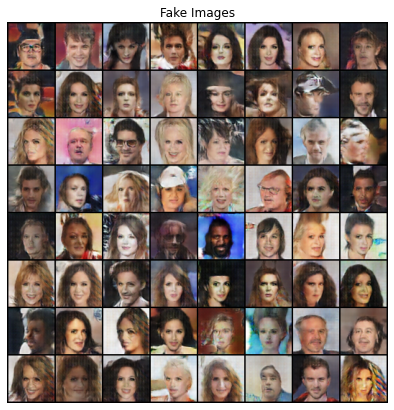

In [25]:
# Generated Images

#for epoch in range(1,41,2):
fake = netG(fixed_noise).detach().cpu()

plt.figure(figsize=(7, 7))
plt.subplot(1,1,1)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(fake, padding=2, normalize=True),(1,2,0)))
plt.show()

In [22]:
# load params

state_dict = torch.load('/content/drive/MyDrive/Colab Notebooks/코드 실습/EBGAN-PT_CelebA_200epochs')
netG.load_state_dict(state_dict['EBGAN-PT_G'])
netD.load_state_dict(state_dict['EBGAN-PT_D'])


<All keys matched successfully>

In [ ]:
X = []
for _ in range(10):
  a = torch.randn(nz,1,1)
  b = torch.randn(nz,1,1)
  X.append(np.linspace(a,b,10))
X = torch.Tensor(np.array(X).reshape(100,100,1,1)).to(device)
images = netG(X).detach().cpu()
plt.figure(figsize=(13,13))
plt.imshow(np.transpose(vutils.make_grid(images, padding=2, normalize=True, nrow=10),(1,2,0)))
plt.show()